In [1]:
from brainiak.factoranalysis.tfa import TFA
from brainiak.factoranalysis.htfa import HTFA
import hypertools as hyp
import nilearn.plotting as niplot
from nilearn.input_data import NiftiMasker
import nibabel as nib
import wget
import zipfile
import os
import glob
from IPython.display import YouTubeVideo
import numpy as np
import seaborn as sns

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Background and overview #

We'll be learning how to create movies of dynamic brain networks using single-subject and multi-subject fMRI data.  After getting the dataset and wrangling it into the proper format, there are three basic steps:
1. Use Hierarchical Topographic Factor Analysis (HTFA) to obtain a set of network "hubs," and the moment-by-moment hub activations.  Model details may be found [here](http://www.biorxiv.org/content/early/2017/02/07/106690).  This creates a simplified version of the full-brain data that is especially useful for computing dynamic network patterns.
1. Use the hub activactions to compute the moment-by-moment connectivity matrix reflected by the data.  We will be using a modified version of Inter-Subject Functional Connectivity (ISFC), which you can read more about [here](https://docs.wixstatic.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf).
1. Use [nilearn](http://nilearn.github.io/) and [hypertools](http://hypertools.readthedocs.io/en/latest/) to visualize the results and create pretty animations.

## Experiment ##
We'll be exploring a part of a dataset collected by Uri Hasson's lab.  The experiment had 36 participants listen *Pie Man*, a story told by Jim O'Grady as part of *The Moth* live storytelling event.  You can listen to the story here:

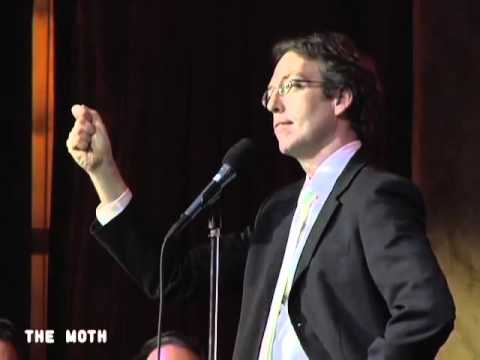

In [9]:
YouTubeVideo('3nZzSUDECLo')

## Data ##
The dataset comprises 36 preprocessed .nii files, and may be downloaded [here](http://dataspace.princeton.edu/jspui/handle/88435/dsp015d86p269k).  However, in the interest of running the analyses quickly, for this tutorial we're going to be working with data from just 4 participants participants.  This smaller dataset may be downloaded [here](https://dartmouth.box.com/s/535yzfqvsmfdiy9jrl65bb5x6rtc7ss4).

## Other datasets to explore ##
[This repository](http://dataspace.princeton.edu/jspui/handle/88435/dsp0147429c369) has a bunch of interesting fMRI datasets in the same format as the sample dataset we'll explore below.

[This dataset](https://dartmouth.box.com/s/gs30hsyk6gsmr8oe5993fr10kuacluo7) collected by Jim Haxby's lab comprises fMRI data as people watched *Indiana Jones: Raiders of the Lost Ark*.



In [3]:
#Download the data (takes a few minutes...)
source = '....'
destination = '/mnt/mini_raiders.zip'

#FIGURE OUT HOW TO DOWNLOAD FROM BOX OR DROPBOX...

In [4]:
#Unzip the data
#zipfile.ZipFile(destination, 'r').extractall()
niifiles = glob.glob(os.path.join(destination[0:-4], '*.nii.gz'))

### Data formatting: .nii --> matrix format ###
To computing HTFA-derived brain networks, we're going to first convert the .nii files into [CMU format](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/README-data-documentation.txt), inspired by Tom Mitchell's website for his 2008 Science paper on predicting brain responses to common nouns ([link](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html)).

We'll create a dictionary for each .nii (or .nii.gz) file with two elements:
- `data`: a number-of-timepoints by number-of-voxels matrix of voxel activations
- `R`: a number-of-voxels by 3 matrix of voxel locations

In [35]:
def nii2cmu(nifti_file, mask_file, zscore, detrend, smoothing_fwmw):
    if mask_file is None:
        #whole brain, get coordinate info from nifti_file itself
        mask = nib.load(nifti_file)
    else:
        mask = nib.load(mask_file)
    affine = mask.affine
    if mask_file is None:
        mask_data = mask.get_data()
        if mask_data.ndim == 4:
            #get mask in 3D
            img_data_type = mask.header.get_data_dtype()
            n_tr = mask_data.shape[3]
            mask_data = mask_data[:,:,:,n_tr//2].astype(bool)
            mask = nib.Nifti1Image(mask_data.astype(img_data_type), affine)
        else:
            mask_data = mask_data.astype(bool)
    else:
        mask_data = mask.get_data().astype(bool)

    #get voxel coordinates
    R = np.float64(np.argwhere(mask_data))

    #get scanner RAS coordinates based on voxel coordinates
    if affine is not []:
        R = (np.dot(affine[:3,:3], R.T) + affine[:3,3:4]).T

    #get ROI data, and run preprocessing
    nifti_masker = NiftiMasker(mask_img=mask, standardize=zscore, detrend=detrend, smoothing_fwhm=smoothing_fwmw)
    img = nib.load(nifti_file)
    all_images = np.float64(nifti_masker.fit_transform(img))
    data = all_images.copy()

    return {'data': data, 'R': R}

In [25]:
mask_file = None #optionally specify a mask to apply to the images
zscore = True #z-score the data (within voxel)?
detrend = True #de-trend the data?
smoothing_fwmw = False #smooth the data?  (this specifies the smoothing radius)

cmu_data = list(map(lambda n: nii2cmu(n, mask_file, zscore, detrend, smoothing_fwmw),  niifiles[0:3]))

## Voxel locations

We can get explore the nitty-gritties of the data by visualizaing the voxel activations and voxel locations.  For example, let's try plotting the voxel locations (`R`) for the first subject:

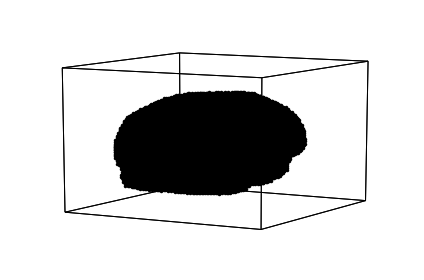

In [6]:
locations = hyp.plot(cmu_data[0]['R'], 'k.') #fun fact: also returns the voxel locations

## Voxel activations

And now let's plot the voxel activation matrices.  For fun, let's plot the first subject's data as a trajectory.  We'll first project the data down to 3 dimensions using Incremental PCA.  HyperTools supports a wide variety of dimensionality reduction algorithms (more info [here](http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot)).  Try changing the next cell to reduce the data using Multidimensional Scaling (hint: `model='MDS'`).

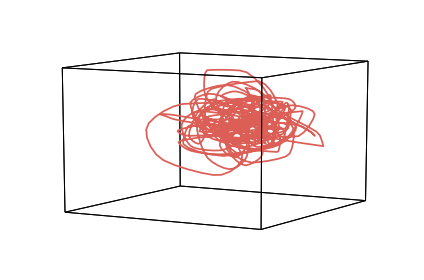

In [40]:
activations = hyp.plot(cmu_data[0]['data'], model='IncrementalPCA')

## Converting between (timepoints by voxels) and (voxels by timepoints) ##

HyperTools and nilearn expect the data matrices to have number-of-timepoints rows and number-of-voxels columns.  BrainIAK expects the data in the transpose of that format-- number-of-voxels by number-of-timepoints matrices.  We can easily convert between the two formats using the `map` function.

In [42]:
htfa_data = list(map(lambda x: {'R': x['R'], 'data': x['data'].T}, cmu_data))

# Using Topographic Factor Analysis to finding network "hubs" in one subject's data #

Applying [Topographic Factor Analysis](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094914) (TFA) to a single subject's data reveals a set of `K` spherical network hubs that may be used to characterize the data in a highly compact form that is convenient for summarizing network patterns.  Let's apply TFA to one subject's data and plot the resulting network hubs.